In [1]:
import pandas as pd  
import matplotlib.pyplot as plt # for visualization
%matplotlib inline
import seaborn as sns # for visualization
from glob import glob  # find pattern in directory

from category_encoders import OneHotEncoder  # For encoding non-numeric value (transformer)
from sklearn.pipeline import make_pipeline # Pipeline (package both transformer and  predictor)
from sklearn.linear_model import Ridge  # Linear Model Building
from sklearn.impute import SimpleImputer  # Impute missing values (transformer)
from sklearn.metrics import mean_absolute_error # Performance Metrics
from sklearn.utils.validation import check_is_fitted  # Check if model is fitted or not
from sklearn.model_selection import train_test_split # split dataset into training set and test set
from ipywidgets import interact, Dropdown, IntSlider, FloatSlider # For interactive jupyter widget 

In [41]:
def wrangle(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath)
    
    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    
    df = df[mask_ba & mask_apt & mask_price]
    
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low,high = df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_area]
    
    # Split lat-lon col
    df[["lat","lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float) 
    df.drop(columns=["lat-lon"], inplace=True)
    
    # Get place name(neighborhood)
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns=["place_with_parent_names"], inplace=True)
    
    # Drop features with high null values
    df.drop(columns=["floor","expenses"],inplace=True)
    
    # Drop features with low- and high-cardinality
    df.drop(columns=["operation", "property_type", "currency", "properati_url"],inplace=True)
    
    # Drop leaky columns
    df.drop(columns=[
     'price',
     'price_aprox_local_currency',
     'price_per_m2',
     'price_usd_per_m2'
    ], inplace=True)
    
    # Drop columns with multicolinearity
    df.drop(columns=["surface_total_in_m2","rooms"],inplace=True)
    
    return df
    


In [42]:
# getting csv filename from diretory
files = glob("F:Datasets/buenos-aires-*.csv")
files

['F:Datasets\\buenos-aires-1.csv',
 'F:Datasets\\buenos-aires-2.csv',
 'F:Datasets\\buenos-aires-3.csv',
 'F:Datasets\\buenos-aires-4.csv',
 'F:Datasets\\buenos-aires-5.csv']

In [43]:
# getting all the csv file together in frame
frames = [wrangle(file) for file in files]

In [44]:
# combine/concate all file in frame (along the rows)
df = pd.concat(frames, ignore_index=True) 

In [45]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


Find  
i. Missing values   
ii. low and high cardinality  
iii. leakage (leaky columns)  
iv. multicolinearity

## Explore

In [19]:
# Look at the columns for missing Values

df.isnull().sum() # count total null values in each columns
(df.isnull().sum() / len(df))*100    # count total per% of null values in each column

operation                      0.000000
property_type                  0.000000
price                          0.000000
currency                       0.000000
price_aprox_local_currency     0.000000
price_aprox_usd                0.000000
surface_total_in_m2           27.803099
surface_covered_in_m2          0.000000
price_usd_per_m2              31.084777
price_per_m2                   0.000000
floor                         71.133394
rooms                         19.690064
expenses                      73.579459
properati_url                  0.000000
lat                            4.041325
lon                            4.041325
neighborhood                   0.000000
dtype: float64

modify wrangle function to drop columns having more than half null values

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   object 
 13  properati_url               6582 

Next thing we need to look out for categorical features having low and high cardinality

In [26]:
# We know that all categorical columns in our dataset are of object type
df.select_dtypes("object")
# Look for unique value in each categorical column so we can find out cardinality
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

In [27]:
df.select_dtypes("object").head()
# low cardinality features: operation, property_type, currency
# High cardinality features: properati_url

,operation,property_type,currency,properati_url,neighborhood
0,sell,apartment,USD,http://chacarita.properati.com.ar/10qlv_venta_...,Chacarita
1,sell,apartment,USD,http://villa-luro.properati.com.ar/12m82_venta...,Villa Luro
2,sell,apartment,USD,http://caballito.properati.com.ar/11wqh_venta_...,Caballito
3,sell,apartment,USD,http://constitucion.properati.com.ar/k2f0_vent...,Constitución
4,sell,apartment,USD,http://once.properati.com.ar/suwa_venta_depart...,Once


In [33]:
# Drop leaky columns
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

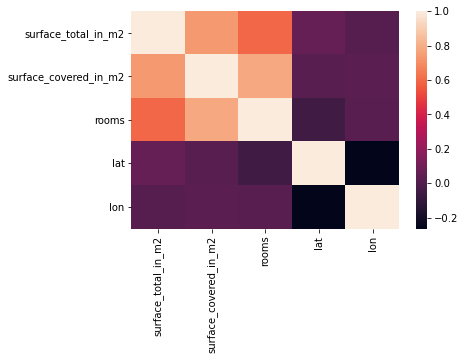

In [39]:
# Drop columns with multicolinearity
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
# Heatmap to visualise correlation between features
sns.heatmap(corr);

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


Amongs surface_total_in_m2, surface_covered_in_m2 and room which are positively correlated(showing multiclolinearity) we have to drop others and take any one out of it, question is which one to choose ?  
Well our data itself has answer for us, surface_covered_in_m2 has zero null value, so we are selecting this one.


## Split Data

In [46]:
features = ["surface_covered_in_m2","lat","lon","neighborhood"]
target = "price_aprox_usd"

In [47]:
X = df[features]
y = df[target]

In [48]:
# Spliting data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size= 0.8, shuffle=True)

## Build Model

### Baseline Model

The first step in building a model is baselining. It's always a model makes only one prediction — in this case, it predicts the same price regardless of feature, often times that single prediction in mean value of actual prediction of training set

In [49]:
y_mean = round(y_train.mean(),2)
y_pred_train = [y_mean]  * len(y_train)

print("Mean apt. price:", y_mean)
# model evaluation
print("Baseline MEA",mean_absolute_error(y_train,y_pred_train).round(2))

Mean apt. price: 132484.13
Baseline MEA 44668.37


### Iterate

We are making pipeline, in which we are putting our transformer and predictor toghether, so that their is no need of transformation and prediction seperately.

In [50]:
# Instantiate
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

(i) OneHotEncoder encode the non numeric value to numeric value, cause we need numeric value to fit our linear regression model.    

(ii) Simple Imputer impute the missing values, dropping the missing value is not a good idea because our model fit well on more data.   

(iii) Ridge Regression is type of linear regression, we are using ridge to predict outcome. we are using Ridge instead of Linear Regression's linear model, because it regularize our model to dataset and keep the values of parameter of our model close to zero.  

In [51]:
# Fit
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [52]:
# Check your work
check_is_fitted(model[-1])

In [53]:
# Predict
y_pred_train = model.predict(X_train)
print("MEA Training:", mean_absolute_error(y_train,y_pred_train).round(2))

MEA Training: 24092.36


After looking at performance we can say that our model are working fine, which having low mea of aprox $20,000 than our baseline mea.

#### Testing Model

In [54]:
# Test model on testing set
y_pred_test = pd.Series(model.predict(X_test))

In [55]:
y_pred_test.head()

0    149198.307730
1    116774.462470
2    157007.076231
3    233829.404486
4    207488.334547
dtype: float64

In [56]:
# Evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred_test).round(2))

Mean Absolute Error: 24903.45


Performance of our model on test set is way better than baseline model, mean our model are generalizing well.

## Communicate Result

Two ways to communicate result  
(i) wrap your model into function so that programmer can provide input and receive pridiction as output

In [57]:
def make_prediction(area,lat,lon,neighborhood):
    data = {
        "surface_covered_in_m2":area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
    }
    df = pd.DataFrame(data, index=["h"])
    prediction = model.predict(df)[0].round(2)
    return f"Predicted Aprtment Price: {prediction}"

In [58]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted Aprtment Price: 251604.9'

(ii) Interactive widget

In [59]:
# Create a interact function in jupyter Widgets

interact(
    make_prediction,
    
    area = IntSlider(
        min = X_train["surface_covered_in_m2"].min(),
        max = X_train["surface_covered_in_m2"].max(),
        value = X_train["surface_covered_in_m2"].mean()
    ),
    
    lat = FloatSlider(
        min = X_train["lat"].min(),
        max = X_train["lat"].max(),
        step =0.01,
        value = X_train["lat"].mean()
    ),
    lon = FloatSlider(
        min = X_train["lon"].min(),
        max = X_train["lon"].max(),
        step = 0.01,
        value = X_train["lon"].mean()
    ),
    neighborhood = Dropdown(options=sorted(X_train["neighborhood"].unique())),
    
);

interactive(children=(IntSlider(value=53, description='area', min=30), FloatSlider(value=-34.598959159051525, …